In [1]:
from meshparty import meshwork
from meshparty import trimesh_io, trimesh_vtk, skeletonize, mesh_filters
from meshparty import skeletonize
from scipy import sparse
from scipy import ndimage
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nglui.statebuilder.helpers import make_neuron_neuroglancer_link
import requests
from PIL import Image

/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/python_jsonschema_objects/__init__.py:113: UserWarning: Schema id not specified. Defaulting to 'self'
  warnings.warn("Schema id not specified. Defaulting to 'self'")


In [2]:
# you should pick a location to save meshes, MeshMeta will cache them there so you don't 
# load them over and over.
# this will make a directory in the current directory of this notebook called meshes
# mm = trimesh_io.MeshMeta(cv_path = client.info.segmentation_source())

mesh_folder = 'meshes'

mm = trimesh_io.MeshMeta(cv_path ="graphene://https://minnie.microns-daf.com/segmentation/table/minnie65_public",
                         disk_cache_path=mesh_folder,
                         cache_size=0)

In [3]:
rid = 864691134884807418 #864691135162983725
sid = 518848 #495010

# get the axon segment from soma to tip of the axon in the whitematter

In [4]:
# set up path for different skeletons

import skeleton_plot as skelplot
import skeleton_plot.skel_io as skel_io

#raw skeleton files
skel_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/v661/skeletons/'

skel_dir = str(rid)+'_'+str(sid) #'864691134884807418_518848'
skel_filename = str(rid)+'_'+str(sid)+'.swc' #'864691134884807418_518848.swc'

# layer aligned
layer_aligned_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/layer_align/v661/'

# polygon files (layer bounds for each cell)
# gives 2d shape for each layer 
layer_bounds_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/poly_files/v661_polys/'

# average layer bounds from IVSCC (to which layer aligned celled are alligned)
# this just gives a single value for each layer (straight line)
layer_bounds_average_path = "https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/avg_layer_depths/"
avg_layerdepths_filename = 'mouse_me_and_met_avg_layer_depths.json'

depths = skel_io.read_json(layer_bounds_average_path, avg_layerdepths_filename)
depths

{'2/3': 115.1112491335,
 '4': 333.4658190171,
 '5': 453.6227158132,
 '6a': 687.6482650269,
 '6b': 883.1308910545,
 'wm': 922.5861720311}

In [5]:
# using layer aligned skel to get the axon segment in the white matter

swc_path = f'{layer_aligned_path}{sid}.swc'
swc_file = skel_io.read_swc(swc_path)

df_axon_seg = swc_file.loc[swc_file.type == 2,]
df_axon_seg['depth'] = df_axon_seg['y']*(-1)
df_axon_seg

layer_keys = ['1','2/3','4','5','6a','6b','wm']
layer_boundaries = np.array(list(depths.values()))
# Create a function to assign layers based on depth
def assign_layer(depth):
    num_layers = len(layer_boundaries)
    
    # Check if depth is below the first boundary
    if depth <= layer_boundaries[0]:
        return layer_keys[0]
    
    # Check if depth is above the last boundary
    if depth > layer_boundaries[num_layers - 1]:
        return layer_keys[num_layers]
    
    # Check if depth is within other boundaries
    for i in range(num_layers - 1):
        if depth > layer_boundaries[i] and depth <= layer_boundaries[i + 1]:
            return layer_keys[i + 1]

# Update using .loc for setting the 'layer' column
for index, row in df_axon_seg.iterrows():
    df_axon_seg.loc[index, 'layer'] = assign_layer(row['depth'])

df_axon_wm = df_axon_seg.loc[df_axon_seg['layer'] == 'wm'].id

/var/folders/w4/p4yxd52x0mb02jrynpfgj3sw0000gr/T/ipykernel_87622/14313382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_axon_seg['depth'] = df_axon_seg['y']*(-1)
/var/folders/w4/p4yxd52x0mb02jrynpfgj3sw0000gr/T/ipykernel_87622/14313382.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_axon_seg.loc[index, 'layer'] = assign_layer(row['depth'])


In [7]:
max(df_axon_wm)

1677

In [8]:
# get the vertices of path from endpoint to root in the raw skeleton

# raw skel
skel = skel_io.read_skeleton(skel_path, skel_filename)
end_points = skel.end_points
end_points

array([ 693, 1128, 1440, 1677, 2035, 2260, 2272, 2509, 2802, 2992, 3269,
       3479, 3610, 3742, 3799, 4011, 4218, 4428, 4592, 4625, 4773, 4826,
       4933, 4958, 5008, 5086, 5221, 5403, 5409, 5447, 5606, 5640, 5686,
       5720, 5918, 5924, 6088, 6234, 6271, 6335, 6438, 6455, 6578, 6685,
       6713, 6741, 6820, 6847, 6901, 6941, 6972, 7043, 7095, 7135, 7164,
       7224, 7270, 7373, 7379, 7467, 7531, 7582, 7680, 7770, 7856, 7946,
       7969, 8054, 8124, 8209, 8293, 8371, 8455, 8532, 8614, 8689, 8721,
       8723, 8801, 8804, 8869, 8939, 8942, 8992, 9054, 9119, 9181, 9244,
       9305, 9325, 9399, 9446, 9485, 9488, 9528, 9579, 9614, 9616, 9630,
       9633, 9670, 9692, 9695, 9747, 9778, 9824, 9838, 9861, 9867, 9873])

In [10]:
path_to_root = skel.path_to_root(max(df_axon_wm))
path_to_root

array([1677, 1676, 1675, 1674, 1673, 1672, 1671, 1670, 1669, 1668, 1667,
       1666, 1665, 1664, 1663, 1662, 1661, 1660, 1659, 1658, 1657, 1656,
       1655, 1654, 1653, 1652, 1651, 1650, 1649, 1648, 1647, 1646, 1645,
       1644, 1643, 1642, 1641, 1640, 1639, 1638, 1637, 1636, 1635, 1634,
       1633, 1632, 1631, 1630, 1629, 1628, 1627, 1626, 1625, 1624, 1623,
       1622, 1621, 1620, 1619, 1618, 1617, 1616, 1615, 1614, 1613, 1612,
       1611, 1610, 1609, 1608, 1607, 1606, 1605, 1604, 1603, 1602, 1601,
       1600, 1599, 1598, 1597, 1596, 1595, 1594, 1593, 1592, 1591, 1590,
       1589, 1588, 1587, 1586, 1585, 1584, 1583, 1582, 1581, 1580, 1579,
       1578, 1577, 1576, 1575, 1574, 1573, 1572, 1571, 1570, 1569, 1568,
       1567, 1566, 1565, 1564, 1563, 1562, 1561, 1560, 1559, 1558, 1557,
       1556, 1555, 1554, 1553, 1552, 1551, 1550, 1549, 1548, 1547, 1546,
       1545, 1544, 1543, 1542, 1541, 1540, 1539, 1538, 1537, 1536, 1535,
       1534, 1533, 1532, 1531, 1530, 1529, 1528, 15

In [11]:
axon_vertices = skel.vertices[path_to_root]
axon_vertices

array([[1175.192, 1070.92 , 1012.6  ],
       [1175.474, 1070.315, 1011.622],
       [1175.943, 1069.585, 1010.394],
       ...,
       [1197.113,  499.868,  917.202],
       [1196.961,  498.442,  917.674],
       [1196.352,  492.736,  919.56 ]])

In [12]:
node_path_length = []

for node in path_to_root:
    node_path_length.append(skel.path_length(skel.path_to_root(node)))

node_path_length

[658.0455,
 656.8614,
 655.3578,
 653.8479,
 652.39,
 650.89746,
 649.38873,
 647.87854,
 646.3782,
 644.87744,
 643.3862,
 641.87714,
 640.36694,
 638.8582,
 637.3544,
 635.866,
 634.36395,
 632.85345,
 631.3507,
 629.84045,
 628.34534,
 626.8517,
 625.3494,
 623.8434,
 622.3485,
 620.8577,
 619.3479,
 617.8385,
 616.3357,
 614.8259,
 613.3308,
 611.8229,
 610.35205,
 608.85364,
 607.34546,
 605.8358,
 604.35046,
 602.84155,
 601.3323,
 599.82263,
 598.3441,
 596.83386,
 595.32404,
 593.82916,
 592.37024,
 590.8816,
 589.3759,
 587.86566,
 586.38995,
 584.9786,
 583.4687,
 581.99695,
 580.4865,
 578.9785,
 577.47046,
 575.97284,
 574.4718,
 572.96814,
 571.4584,
 569.9901,
 568.48047,
 566.9746,
 565.46954,
 563.98486,
 562.4873,
 560.98816,
 559.4807,
 557.97363,
 556.63245,
 555.14087,
 553.63916,
 552.1504,
 550.6404,
 549.1455,
 547.6412,
 546.1331,
 544.6448,
 543.1746,
 541.6782,
 540.2057,
 538.72473,
 537.21533,
 535.71765,
 534.23975,
 532.73364,
 531.22394,
 529.7384,
 528.2

# estimate radius along the axonal segment

In [14]:
post_mesh = mm.mesh(seg_id = rid)
average_radius = []

for vertices in axon_vertices:
    pt_ctr = vertices * 1000
    filt = mesh_filters.filter_spatial_distance_from_points(
        post_mesh,
        pt_ctr,
        d_max=3_000,
    )
    filt_mesh = post_mesh.apply_mask(filt)

    # skeletonize the mesh using a 12 um invalidation radius
    # assuming units of mesh.vertices is in nm
    sk = skeletonize.skeletonize_mesh(filt_mesh,
                          invalidation_d=12000)
    average_radius.append(np.mean(sk.radius))
    average_radius

average_radius


/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/meshparty/skeletonize.py:622: RuntimeWarning: invalid value encountered in multiply
  target = np.nanargmax(root_ds * valid)


[619.9571349843734,
 593.4486649989844,
 585.8665841863021,
 547.9791835636037,
 557.5447084939675,
 550.5885759477748,
 591.756086516467,
 473.0041390900772,
 520.8390556313502,
 484.5793620816618,
 499.4204579529318,
 485.21753299973585,
 428.2722440214871,
 415.52663199918624,
 456.49262024660976,
 414.6829555558496,
 514.3045042626411,
 467.33298718594466,
 374.6142014601535,
 435.28062183905564,
 433.9477227776228,
 343.65804323944195,
 521.3927627340656,
 398.03440957511305,
 429.95510413714806,
 395.18225641246903,
 431.11991113026244,
 420.6646004859928,
 423.71128033179036,
 458.1893995844333,
 506.5479379260879,
 443.0651996767853,
 424.260158421599,
 380.8610426503974,
 399.347406194986,
 486.20236056324,
 454.92295649971265,
 488.48924383485513,
 639.234363815342,
 473.3877510303325,
 580.9573901136488,
 591.8817667172111,
 463.23205292370113,
 554.3374937693656,
 513.5879047488856,
 441.51795798852885,
 405.61670554575244,
 428.51386083138175,
 437.7224422708721,
 508.2185

/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packag

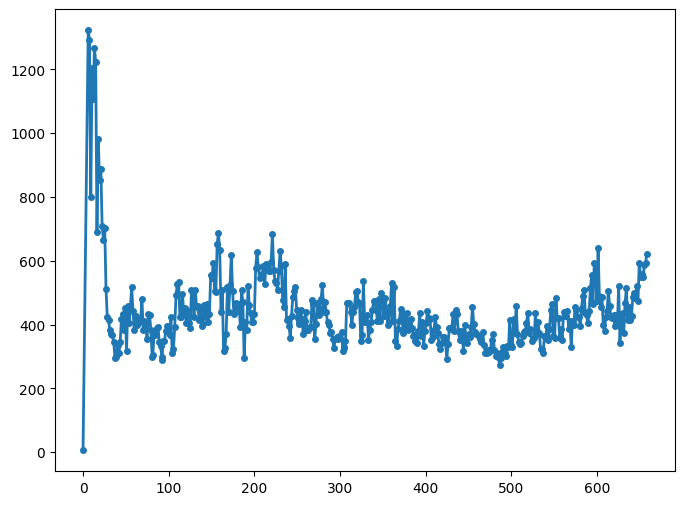

In [15]:
fig = plt.figure(figsize=(8, 6))

#plt.scatter(node_path_length, average_radius)
plt.plot(node_path_length, average_radius, marker='o', linestyle='-', linewidth=2, markersize=4, label='Line Plot')

# detect myelin wrapping around the axonal segment

In [16]:
from caveclient import CAVEclient
import imageryclient as ic

datastack_name = 'minnie65_public_v661'
client = CAVEclient(datastack_name)

img_client = ic.ImageryClient(client=client)


### currently only work with 2D xy-section 

In [18]:
import numpy as np
from scipy import ndimage

def compute_mylin_wrap(img_client, center, root_id, img_width=1024, depth=1, dilation_iterations=3):
    # Calculate bounding box
    bounds = ic.bounds_from_center(center, width=img_width, height=img_width, depth=depth)
    
    # cut out segmentation data with only the neuron interested in
    seg_rid = img_client.segmentation_cutout(bounds, root_ids=root_id)
    # calculate binary masks
    bseg = seg_rid > 0
    # dilating the segmentation data
    seg_new = ndimage.binary_dilation(bseg, iterations=dilation_iterations, border_value=0)
    # get the dilated outline of the segmentation
    seg_new[bseg] = 0

    # cut out all segmentation data (seg_all == 0 indicates myelin and others unsegmented stuff)
    seg_all = img_client.segmentation_cutout(bounds)
    
    # calculate binary masks
    seg_0 = seg_all == 0
    # dilated outline falls on seg_all is 0
    seg_mylin = seg_0 & seg_new
    
    # Calculate the metric (percentage of pixels where seg_all is 0)
    if seg_new is not None:
        metric = np.sum(seg_all[seg_new] == 0) / len(seg_new[seg_new == True]) * 100
    else:
        metric = None
    
    return metric 

# Example usage:
# result = compute_mylin_wrap(img_client, center=[304176, 263880, 23199.275], root_id=rid)


In [ ]:
mylin_wrap = []

# Loop through each set of axon vertices
for asid, as_vertices in enumerate(axon_vertices):
    # get center point
    ctr = as_vertices * 1000 / np.array([4, 4, 40])
    
    # calculate mylin metric
    result = compute_mylin_wrap(img_client, center=ctr, root_id=rid)
    
    mylin_wrap.append(result)

In [ ]:
fig = plt.figure(figsize=(8, 6))

#plt.scatter(node_path_length, average_radius)
plt.plot(node_path_length, mylin_wrap, marker='o', linestyle='-', linewidth=2, markersize=4, label='Line Plot')

In [191]:
# saving data to file
df = pd.DataFrame({'x':axon_coordinates[:,0],'y':axon_coordinates[:,1],'z':axon_coordinates[:,2],'Axon_to_Soma Length': node_path_length, 'Mylin_Metric': mylin_wrap, 'Axon_Radius': average_radius})

file_path = f'/Users/wanqing.yu/Documents/GitHub/EM connectome/data/{rid}_myelin.csv'
df.to_csv(file_path)

In [192]:
df

,x,y,z,Axon_to_Soma Length,Mylin_Metric,Axon_Radius
0,293798.00,267730.00,25315.000,658.045471,100.000000,619.940786
1,293868.50,267578.75,25290.550,656.861389,100.000000,593.473115
2,293985.75,267396.25,25259.850,655.357788,92.407407,585.885073
3,294143.00,267228.75,25229.900,653.847900,100.000000,547.969566
4,294398.75,267093.25,25207.750,652.390015,100.000000,557.544772
...,...,...,...,...,...,...
436,299354.25,125680.25,22906.475,10.570292,0.000000,1203.716253
437,299316.25,125323.50,22918.275,9.059590,0.000000,799.293123
438,299278.25,124967.00,22930.050,7.550146,0.000000,1293.003277
439,299240.25,124610.50,22941.850,6.040390,0.000000,1322.537723


/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packag

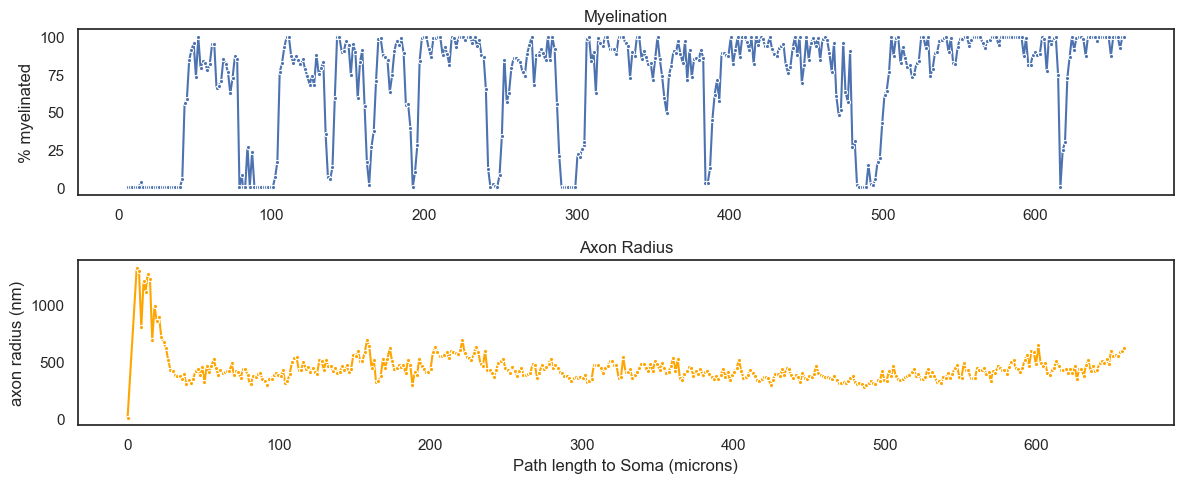

In [194]:
# Set Seaborn style
sns.set(style="white")

# Plot Axon_to_Soma Length vs Mylin_Metric using Seaborn
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
#sns.scatterplot(data=df, x='Axon_to_Soma Length', y='Mylin_Metric')
sns.lineplot(data=df, x='Axon_to_Soma Length', y='Mylin_Metric', marker='.')
plt.title('Myelination')
plt.xlabel('')
plt.ylabel('% myelinated')


# Plot Axon_to_Soma Length vs Axon_Radius using Seaborn
plt.subplot(2, 1, 2)
#sns.scatterplot(data=df, x='Axon_to_Soma Length', y='Axon_Radius')
sns.lineplot(data=df, x='Axon_to_Soma Length', y='Axon_Radius', marker='.', color='orange')
plt.title('Axon Radius')
plt.xlabel('Path length to Soma (microns)')
plt.ylabel('axon radius (nm)')

# Adjust layout and show plots
plt.tight_layout()
plt.show()


# loading data from file

In [ ]:
rid = 864691135162983725

In [5]:
file_path_tmp = f'/Users/wanqing.yu/Documents/GitHub/EM-connectome/data/{rid}_myelin.csv'

df_tmp = pd.read_csv(file_path_tmp)
df_tmp

,Unnamed: 0,x,y,z,Axon_to_Soma Length,Mylin_Metric,Axon_Radius
0,0,308309.25,264298.00,23265.950,442.640600,96.471774,599.349105
1,1,307934.50,264255.50,23264.950,441.131470,76.345561,635.839939
2,2,307557.50,264240.75,23263.475,439.621150,69.018024,617.378951
3,3,307185.25,264190.25,23261.050,438.115400,62.026940,654.513216
4,4,306814.00,264129.50,23258.075,436.605960,62.962963,696.277346
...,...,...,...,...,...,...,...
288,288,288537.50,195825.00,19549.000,12.079796,0.000000,1323.728833
289,289,288424.25,195465.00,19549.000,10.570224,0.000000,1181.564279
290,290,288311.00,195104.75,19549.000,9.059697,0.000000,421.405374
291,291,288198.00,194744.75,19549.000,7.550424,0.000000,269.557065


/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packag

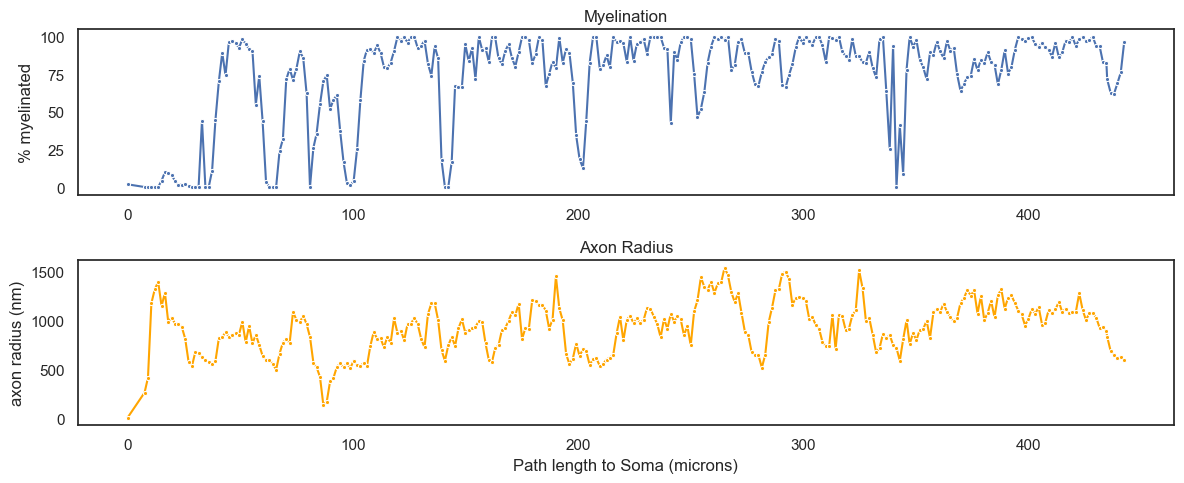

In [198]:
# Set Seaborn style
sns.set(style="white")

# Plot Axon_to_Soma Length vs Mylin_Metric using Seaborn
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
#sns.scatterplot(data=df, x='Axon_to_Soma Length', y='Mylin_Metric')
sns.lineplot(data=df_tmp, x='Axon_to_Soma Length', y='Mylin_Metric', marker='.')
plt.title('Myelination')
plt.xlabel('')
plt.ylabel('% myelinated')


# Plot Axon_to_Soma Length vs Axon_Radius using Seaborn
plt.subplot(2, 1, 2)
#sns.scatterplot(data=df, x='Axon_to_Soma Length', y='Axon_Radius')
sns.lineplot(data=df_tmp, x='Axon_to_Soma Length', y='Axon_Radius', marker='.', color='orange')
plt.title('Axon Radius')
plt.xlabel('Path length to Soma (microns)')
plt.ylabel('axon radius (nm)')

# Adjust layout and show plots
plt.tight_layout()
plt.show()


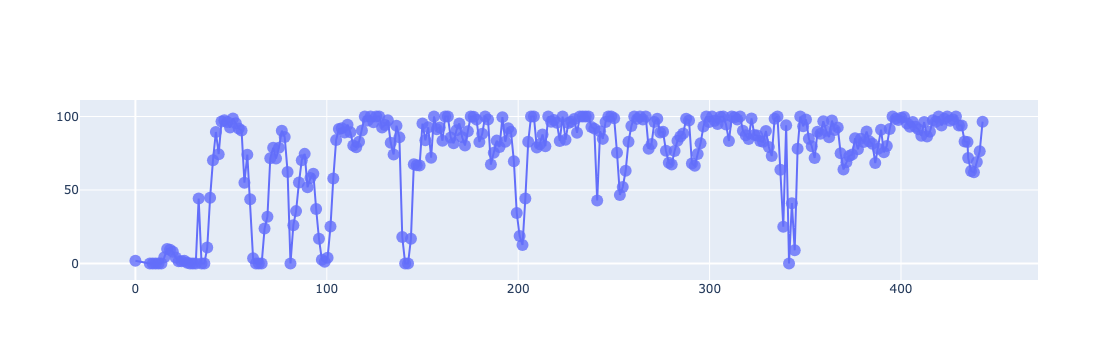

'exampleplot.html'

In [72]:
import pandas as pd
import plotly
import plotly.graph_objects as go

# Sample data

df = df_tmp

# Create a line+marker plot with clickable links
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['Axon_to_Soma Length'],
    y=df['Mylin_Metric'],
    mode='lines+markers',
    hovertext=[f'<a href="{link}">{link}</a>' for link in df['Link']],
    hoverinfo='text',
    marker=dict(size=12, opacity=0.8),
    line=dict(shape='linear')
))

# Update layout
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)

# Show the interactive plot
fig.show()
plotly.offline.plot(fig, filename= f'/Users/wanqing.yu/Documents/GitHub/EM-connectome/data/{rid}_myelin.html')